In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003703149, 'queue_time': 0.46517824799999996, 'total_time': 0.053703149}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-f8eef4c5-9b19-48d8-8cf0-98368c6aaeb0-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

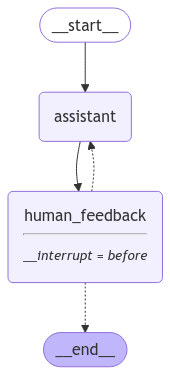

In [15]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# System message
sys_msg = SystemMessage(content="You need to tell a joke based on the user input topic.")

# Assistant node
def assistant(state: MessagesState):
    return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

# Human feedback node
def human_feedback(state: MessagesState):
    return {"messages": state["messages"]}  # Maintain state

# Decision function for human feedback
def evaluate_feedback(state: MessagesState) -> str:
    """Determine whether to continue or end based on user feedback."""
    last_message = state["messages"][-1].content.lower()
    if "fail" in last_message:
        return "assistant"  # ✅ Return a string
    else:
        return END  # ✅ Return END (correct way)

# Graph builder
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("human_feedback", human_feedback)

# Define edges
builder.add_edge(START, "assistant")
builder.add_edge("assistant", "human_feedback")

# Correct conditional edges call
builder.add_conditional_edges(
    "human_feedback", evaluate_feedback, ["assistant", END]
)
builder.add_edge("assistant", "human_feedback")

# Setup memory and compile graph
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Display graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [16]:
initial_input={"messages":HumanMessage(content="Joke topic: Tiger")}

thread={"configurable":{"thread_id":"1"}}

In [17]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Joke topic: Tiger
================================== Ai Message ==================================

Why don't tigers use Facebook? Because they prefer to show their faces in person!


In [24]:
state=graph.get_state(thread)
state.next

('human_feedback',)

In [23]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Joke topic: Tiger', additional_kwargs={}, response_metadata={}, id='b2b28fc6-5146-4681-be0e-c8001ecea05a'), AIMessage(content="Why don't tigers use Facebook? Because they prefer to show their faces in person!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 31, 'total_tokens': 50, 'completion_time': 0.095, 'prompt_time': 0.003907668, 'queue_time': 0.235162119, 'total_time': 0.098907668}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-0213edf1-3c35-47e0-9a23-7d338f843d67-0', usage_metadata={'input_tokens': 31, 'output_tokens': 19, 'total_tokens': 50})]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1eff3acc-c3f4-6728-8001-b0f058d1f271'}}, metadata={'source': 'loop', 'writes': {'assistant': {'messages': [AIMessage(content="Why don't tigers use Fa

In [20]:
graph.update_state(thread,{"messages":[HumanMessage(content="fail")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff3ad4-aac4-6479-8002-63aeb62ddf4f'}}

In [21]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Joke topic: Tiger
================================== Ai Message ==================================

Why don't tigers use Facebook? Because they prefer to show their faces in person!
================================ Human Message =================================

fail


In [22]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

fail
================================ Human Message =================================

fail
================================== Ai Message ==================================

Okay, let's try this one: Why was the tiger not invited to the party? Because he always Roars naked! Just kidding, that one was rough. How about: Why did the tiger get arrested? Because he kept stripping off his stripes near the police station! 

I hope you found that one a bit more amusing!


In [25]:
graph.update_state(thread,{"messages":[HumanMessage(content="fail, send me better joke")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff3ada-0300-6854-8005-ec2ee6ae2b7c'}}

In [26]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Joke topic: Tiger
================================== Ai Message ==================================

Why don't tigers use Facebook? Because they prefer to show their faces in person!
================================ Human Message =================================

fail
================================== Ai Message ==================================

Okay, let's try this one: Why was the tiger not invited to the party? Because he always Roars naked! Just kidding, that one was rough. How about: Why did the tiger get arrested? Because he kept stripping off his stripes near the police station! 

I hope you found that one a bit more amusing!
================================ Human Message =================================

fail, send me better joke


In [27]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

fail, send me better joke
================================ Human Message =================================

fail, send me better joke
================================== Ai Message ==================================

Sure, here's a better one:

Why did the tiger cross the road?

To get to the tiger side of the road!


In [28]:
graph.update_state(thread,{"messages":[HumanMessage(content="Nice joke")]})
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Joke topic: Tiger
================================== Ai Message ==================================

Why don't tigers use Facebook? Because they prefer to show their faces in person!
================================ Human Message =================================

fail
================================== Ai Message ==================================

Okay, let's try this one: Why was the tiger not invited to the party? Because he always Roars naked! Just kidding, that one was rough. How about: Why did the tiger get arrested? Because he kept stripping off his stripes near the police station! 

I hope you found that one a bit more amusing!
================================ Human Message =================================

fail, send me better joke
================================== Ai Message ==================================

Sure, here's a better one:

Why did the tiger cross the road?

To get to the tiger s

In [32]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Nice joke


In [33]:
state=graph.get_state(thread)
state.next

()

In [34]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Joke topic: Tiger', additional_kwargs={}, response_metadata={}, id='b2b28fc6-5146-4681-be0e-c8001ecea05a'), AIMessage(content="Why don't tigers use Facebook? Because they prefer to show their faces in person!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 31, 'total_tokens': 50, 'completion_time': 0.095, 'prompt_time': 0.003907668, 'queue_time': 0.235162119, 'total_time': 0.098907668}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-0213edf1-3c35-47e0-9a23-7d338f843d67-0', usage_metadata={'input_tokens': 31, 'output_tokens': 19, 'total_tokens': 50}), HumanMessage(content='fail', additional_kwargs={}, response_metadata={}, id='d82ede23-9641-4d81-a401-04ab5edb1233'), AIMessage(content="Okay, let's try this one: Why was the tiger not invited to the party? Because he always Roars naked! Just kidding, that one